# Homework 6

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Austin Galm
* agalm@uchicago.edu

In [1]:
import os
import sys
import pandas as pd
from scipy.stats import norm, chi2
import statsmodels.api as sm
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
sys.path.insert(0, parent_dir)
sys.path.insert(0, grandparent_dir)
import cmds.portfolio_management_helper as pmh

plt.style.use("seaborn-v0_8-whitegrid")
PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.4f}".format
p = plt.rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1 The Momentum Product
This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

### 1.1 What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

<span style="color:red;">

AQR's Momentum product is novel because it is a mutual fund, and thus its targeted clientele is retail investors instead of accredited investors. Because it is a mutual fund, it must be:
1. Long-only: legally limited in their use of short positions and leverage
2. Open-end: had to be ready to return capital at the end of the trading day to respond to investor redemptions

</span>

### 1.2 Name three reasons the momentum investment product will not exactly track the momentum index, (ie. why the strategy will have tracking error.)

<span style="color:red;">

1. AQR's mutual fund is long-only, whereas the index (Fama-french UMD) is long-short.
2. The index assumes monthly rebalancing and is agnostic to current positioning. That is, the benchmark may enter completely new positions month-to-month and may also completely exit, which may cause huge transaction costs. 
3. Fama-French UMD uses all listed stocks, whereas AQR's fund only uses stocks with a specified market capitalization and liquidity. This is because of "open-end" mutual fund regulation.

</span>

### 1.3 When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t-12$ through $t-2$. Why don't they include the $t-1$ return in this ranking?

<span style="color:red;">

The winning/losing stocks between $t − 1$ to $t$ may show short-term reversal, such that the momentum strategy would be hurt by including $t − 1$ return in the ranking.

</span>

## 2. Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR's new momentum product.
On Canvas, find the data file, "**momentum_data.xlsx**".
- The first tab contains the momentum factor as an excess return: $\tilde{r}^{\mathrm{mom}}$.
- The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\operatorname{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
  - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
- The third tab gives portfolios sorted by momentum and size.
  - $r^{\text {momsu }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by $\mathrm{FF}$ as,

$$
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right)
$$

In [2]:
data_path = parent_dir + '/data/'
ff_file_name = data_path + 'momentum_data.xlsx'
excess_ff_factors = pmh.read_excel_default(ff_file_name, 
                                 sheet_name='factors (excess returns)',
                                 index_col='Date', parse_dates=True)
excess_momentum = pmh.read_excel_default(ff_file_name, 
                                 sheet_name='momentum (excess returns)',
                                 index_col='Date', parse_dates=True)
total_deciles = pmh.read_excel_default(ff_file_name, 
                                 sheet_name='deciles (total returns)',
                                 index_col='Date', parse_dates=True)
total_size_sorts = pmh.read_excel_default(ff_file_name, 
                                 sheet_name='size_sorts (total returns)',
                                 index_col='Date', parse_dates=True)
rf_rate = pmh.read_excel_default(ff_file_name, 
                                 sheet_name='risk-free rate',
                                 index_col='Date', parse_dates=True)

In [3]:
total_size_sorts

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
date,,,,,,
1927-01-31,0.0008,0.0357,0.0040,-0.0040,0.0026,0.0000
1927-02-28,0.0701,0.0648,0.0551,0.0727,0.0380,0.0447
1927-03-31,-0.0346,-0.0288,-0.0206,-0.0357,-0.0018,0.0226
1927-04-30,-0.0075,-0.0048,0.0332,-0.0272,0.0075,0.0181
1927-05-31,0.0248,0.1115,0.0683,0.0552,0.0496,0.0718
...,...,...,...,...,...,...
2024-05-31,0.0571,0.0483,0.0457,0.0549,0.0287,0.0660
2024-06-30,-0.0241,-0.0138,-0.0311,0.0292,0.0225,0.0542
2024-07-31,0.0900,0.1066,0.1091,0.0474,0.0320,-0.0202


In [4]:
ff_factors = pd.concat([excess_ff_factors, excess_momentum], axis=1)
excess_deciles = total_deciles - rf_rate.values
excess_size_sorts = total_size_sorts - rf_rate.values
display(excess_size_sorts)
display(ff_factors)

,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
date,,,,,,
1927-01-31,-0.0017,0.0332,0.0015,-0.0065,0.0001,-0.0025
1927-02-28,0.0675,0.0622,0.0525,0.0701,0.0354,0.0421
1927-03-31,-0.0376,-0.0318,-0.0236,-0.0387,-0.0048,0.0196
1927-04-30,-0.0100,-0.0073,0.0307,-0.0297,0.0050,0.0156
1927-05-31,0.0218,0.1085,0.0653,0.0522,0.0466,0.0688
...,...,...,...,...,...,...
2024-05-31,0.0527,0.0439,0.0413,0.0505,0.0243,0.0616
2024-06-30,-0.0282,-0.0179,-0.0352,0.0251,0.0184,0.0501
2024-07-31,0.0855,0.1021,0.1046,0.0429,0.0275,-0.0247


,MKT,SMB,HML,UMD
date,,,,
1927-01-31,-0.0006,-0.0037,0.0454,0.0036
1927-02-28,0.0418,0.0004,0.0294,-0.0214
1927-03-31,0.0013,-0.0165,-0.0261,0.0361
1927-04-30,0.0046,0.0030,0.0081,0.0430
1927-05-31,0.0544,0.0153,0.0473,0.0300
...,...,...,...,...
2024-05-31,0.0434,0.0078,-0.0166,-0.0002
2024-06-30,0.0277,-0.0306,-0.0331,0.0090
2024-07-31,0.0124,0.0680,0.0573,-0.0242


The Fama-French momentum return

$$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1 Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2023?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2024 & & & \\
1927-1993 & & & \\
1994-2008 & & & \\
2009-2024 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [5]:
summary_table = pmh.calc_summary_statistics(ff_factors, annual_factor=12, provided_excess_returns=True, 
                            timeframes={'1927-2024':['1927', '2024'],
                                        '1927-1993':['1927', '1993'],
                                        '1994-2008':['1994', '2008'],
                                        '2009-2024':['2009', '2024']},
                            correlations=['MKT', 'HML'],
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness', 'Correlation'])
summary_table.loc[summary_table.index.str.contains('UMD')]

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
UMD 1927-2024,0.0753,0.1625,0.4635,-2.9905,-0.3443,-0.4064
UMD 1927-1993,0.0901,0.1600,0.5630,-3.8082,-0.3625,-0.4950
UMD 1994-2008,0.1044,0.1756,0.5945,-0.5820,-0.2345,-0.1294
UMD 2009-2024,-0.0151,0.1585,-0.0952,-2.6910,-0.3676,-0.3209


#### (b) Has momentum changed much over time, as seen through these subsample statistics?

<span style="color:red;">

The highest return and highest sharpe period among the sub-samples is from 1994-2008, after the paper by Jegadeesh and Titman, and leading up to the great financial crisis. Following the financial crisis, however, Momentum has offered negative annualized mean excess returns. Additionally, it is offering these lower returns with less volatility. Finally, this factor carried a relatively large negative correlation with the MKT and Value factors from 1927-1993, then the correlations went closer to 0 from 1994-2008, and they have recently returned closer to their negative correlations from the first sub-sample.

</span>

#### (c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

<span style="color:red;">

Yes, It was definitely profitable leading up to 2008 when AQR was considering launching the momentum mutual fund. Also, the momentum has a low (negative) correlation with market and value factor, which makes it a good diversifier among factors trying to price the global portfolio. 

Even if the mean return is near zero, momentum still offers low correlation with other factors and, consequently, offers some diversification benefit. However, if returns are negative after transaction costs (which seems likely in the latest sub-sample), then the diversification doesn't offer substantial enough value since it will dramatically reduce portfolio returns. Under these conditions, investors should only consider a small allocation to a Momentum portfolio.

### 2.2. Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


#### (a) Fill out Table 2 for the data in the period 1994-2022.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2023 } & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [6]:
momu_ff = ((total_size_sorts['SMALL HiPRIOR'] + total_size_sorts['BIG HiPRIOR']) / 2 - rf_rate['RF']).to_frame('UMD-L')
momu_ff
momu_ff_factors = pd.concat([ff_factors, momu_ff], axis=1)

summary_table = pmh.calc_summary_statistics(momu_ff_factors.loc['1994':], annual_factor=12, provided_excess_returns=True, 
                            correlations=['MKT', 'HML'],
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness', 'Correlation'])
summary_table.loc[summary_table.index.str.contains('UMD')]

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3062,-0.2152
UMD-L,0.1172,0.1784,0.6569,-0.4448,0.9036,-0.1190


#### (b)  Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

<span style="color:red;">

Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, the volatility is similar, and the Sharpe ratio is consequently higher.

</span>

#### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

<span style="color:red;">

No, the long-only momentum portfolio has >90% correlation with market factor, whereas the long-short momentum portfolio has -34% of correlation with market. The lack of ability to short stocks leads the long-only momentum portfolio to still be exposed to market risks.

</span>

#### (d) Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2023 subsample. $^2$

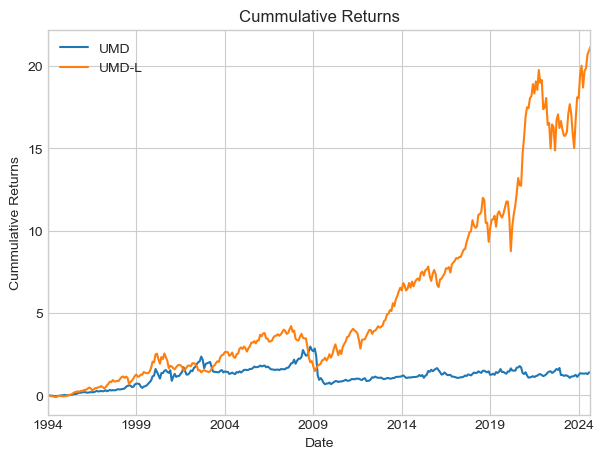

In [7]:
pmh.calc_cummulative_returns(momu_ff_factors.loc['1994':, ['UMD', 'UMD-L']])

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:


$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$


- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

#### (a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2023 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

In [8]:
mom_d1 = ((total_deciles['Hi PRIOR'] - total_deciles['Lo PRIOR']) - rf_rate['RF']).to_frame('momD1')
mom_d3 = ((total_deciles['PRIOR 8'] + total_deciles['PRIOR 9'] + total_deciles['Hi PRIOR']) / 3 - 
          (total_deciles['PRIOR 3'] + total_deciles['PRIOR 2'] + total_deciles['Lo PRIOR']) / 3 -
          rf_rate['RF']).to_frame('momD3')
mom_d5 = ((total_deciles['PRIOR 6'] + total_deciles['PRIOR 7'] + total_deciles['PRIOR 8'] + total_deciles['PRIOR 9'] + total_deciles['Hi PRIOR']) / 5 - 
          (total_deciles['PRIOR 5'] + total_deciles['PRIOR 4'] + total_deciles['PRIOR 3'] + total_deciles['PRIOR 2'] + total_deciles['Lo PRIOR']) / 5 -
          rf_rate['RF']).to_frame('momD5')

momu_dx_ff_factors = pd.concat([ff_factors, mom_d1, mom_d3, mom_d5], axis=1)
summary_table = pmh.calc_summary_statistics(momu_dx_ff_factors.loc['1994':], annual_factor=12, provided_excess_returns=True, 
                            correlations=['MKT', 'HML'],
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness', 'Correlation'])

summary_table.loc[summary_table.index.str.contains('momD')]

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
momD1,0.0586,0.2985,0.1964,-1.3070,-0.3196,-0.2346
momD3,0.0052,0.1931,0.0268,-1.3453,-0.3613,-0.2129
momD5,-0.0070,0.1337,-0.0521,-1.4155,-0.3478,-0.2142


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

<span style="color:red;">

Yes, we can see long-short portfolio with higher threshold of decile has higher return, but also higher volatility.

</span>

#### (c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

<span style="color:red;">

I would recommend 1-decile, as it has higher sharpe.

</span>

#### (d) Does $\tilde{r}^{\text {momD3}}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

In [9]:
summary_table = pmh.calc_summary_statistics(momu_dx_ff_factors.loc['1994':], annual_factor=12, provided_excess_returns=True, 
                            correlations=['MKT', 'HML'],
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness', 'Correlation'])

summary_table.loc[summary_table.index.str.contains('UMD') | summary_table.index.str.contains('momD3')]

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation,HML Correlation
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3062,-0.2152
momD3,0.0052,0.1931,0.0268,-1.3453,-0.3613,-0.2129


<span style="color:red;">

They are similar, but Fama-French construction has higher return and lower volatility, resulting with higher sharpe ratio. Fama-French construction allows balance between small and large stocks, whereas top 3 deciles construction could be biased towards either small or large stocks.

</span>

### 2.4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

#### (a) Fill out Table 4 over the sample 1994-2024.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2024 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [10]:
momS = ((total_size_sorts['SMALL HiPRIOR'] - total_size_sorts['SMALL LoPRIOR']) - rf_rate['RF']).to_frame('momS')
momB = ((total_size_sorts['BIG HiPRIOR'] - total_size_sorts['BIG LoPRIOR']) - rf_rate['RF']).to_frame('momB')

momu_sb_ff_factors = pd.concat([ff_factors, momS, momB], axis=1)
summary_table = pmh.calc_summary_statistics(momu_sb_ff_factors.loc['1994':], annual_factor=12, provided_excess_returns=True, 
                            correlations=['MKT'],
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness', 'Correlation'])

summary_table.loc[summary_table.index.str.contains('UMD') | summary_table.index.str.contains('mom')]

,Annualized Mean,Annualized Vol,Annualized Sharpe,Skewness,MKT Correlation
UMD,0.0432,0.1677,0.2575,-1.4460,-0.3062
momS,0.0398,0.1690,0.2357,-1.7890,-0.3041
momB,-0.0002,0.1823,-0.0011,-0.8933,-0.2793


#### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

<span style="color:red;">

It does appear that the attractiveness of the momentum strategy is mostly drive by the small stock momentum portfolio. For this period of observation, the large stocks momentum strategy delivers virtually zero excess return and has higher annualized volatility. So no, a momentum strategy in large stocks does not deliver excess returns at comparable risk.

</span>

### 2.5. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

<span style="color:red;">

The AQR retail product does not appear to successfully capture the important features of the Fama-French construction of momentum:

* The portfolio is constrained to being long-only, leading it to be highly correlated with the market factor and consequently, eliminating the diversification benefits of a momentum portfolio.
* The portfolio is constrained to investing in large-cap, highly liquid stocks to meet mutual fund requirements. This constraint effectively eliminates the attractive risk-return tradeoff of the momentum portfolio as much of the attractive excess returns come from small stocks.
* The portfolio will not exist in a frictionless market for rebalancing, so frequent transactions will either erode returns or lead to significant tracking error away from the benchmark.

The lazy suggestion to overcome these shortfalls is to not launch the mutual fund and stick with hedge funds that are not subject to these regulatory constraints. But in an effort to imagine a product that can be offered to retail investors, I would suggest AQR launch this fund as an ETF instead of a mutual fund. ETFs do not have the same regulatory constraints as mutual funds. Specifically, an ETF wrapper to this strategy would allow AQR to:

* Take short positions, providing the lower correlation with the market factor.
* Invest in smaller, less liquid companies that have more attractive return profiles.

Though, this solution will not solve the problem of frequent rebalancing.

</span>

## 3. Barnstable's Analysis

### 1. Barnstable’s Philosophy

1. **What has Barnstable’s investment strategy been in the past?**

<span style="color:red;">

   Barnstable had a simple investment philosophy--they believed that stocks would outperform bonds and other "safe-haven" assets in the long-run. Consequently, they invested their endowment portfolio entirely in stocks to take full advantage of the long-run excess-return profile of this asset class.

</span>

2. **Explain the logic behind their view that stocks are safer in the long run.**

<span style="color:red;">

   Barnstable was advised by a securities firm that while expected returns of any security scale linearly with time, the risk of those returns scales at a sub-linear rate. Consequently, the risk of holding higher-returning assets, which implies also assuming higher risk, is significantly diminished over a long time horizon. In this way, long-term holders of these securities could realize a "time-diversification" benefit. Further, stocks were, theoretically, more likely to meet Barnstable's return requirements over the long-run since they offered higher expected returns.

</span>

3. **What assumptions underly Barnstable’s belief in the long-run safety of stocks?**

   1. Stock market movements are serially uncorrelated, and so the uncorrelated movements "cancel" each other out.
   2. Law of Large Numbers points to a sub-linear increase of return volatility with time while returns themselves scale linearly.
   3. ***(Not explicitly stated, but implied)*** Tail-risk events would not be "catastrophic" to the portfolio.

### 2. Two Proposals

1. **Describe the two proposals Barnstable is considering for how to take advantage of their view regarding the long-run safety of stocks.**

<span style="color:red;">

   1. **Put Options Selling Proposal:** The first proposal was that Barnstable sell long-dated put options on the S&P 500 to generate income for their endowment. The idea behind this proposal was that the probability of the options being exercised was low, so selling these options seemed to offer a near-riskless return from the sale premium of the contracts.
   2. **Trust Wrapper Proposal:** The second proposal was that Barnstable college and other investors contribute S&P 500 stocks to a trust managed similarly to an S&P 500 index fund and, in return, receive pairs of preference and common shares proportional to their contribution. They could then sell the preferred shares in the marketplace to raise immediate cash and retain their common shares to maintain their desired exposure to equity returns.

</span>

2. **How is the trust different from simply shorting the risk-free rate to take a levered position in stocks?**

<span style="color:red;">

   The trust is different from simply shorting the risk-free rate and taking a levered position in the stocks because the requirement of the seller of the preferred shares to pay out gains up to the redemption level:

   * If Barnstable shorts the risk-free and takes a levered position, then we realize returns that are just given by a scalar of the market returns. For example, if we take on 10% leverage by borrowing 10% of our principal at the risk-free rate, then we will realize returns in the portfolio equal to 1.1x the market return and have to pay back only the risk-free rate on the 10% borrowed at the end of the period.
   * Under the trust structure, Barnstable is selling preferred shares to receive cash and buy more common stock. However, as the seller of the preferred shares, they are obligated to pay out any gains on the securities up to the redemption value. Consequently, there is a portion of the return profile related to these preferred shares that is "flat." The value difference between this and the borrowing scenario is that, under the trust structure and selling preferred shares, Barnstable must pay out up to 6%, which is (likely) greater than the risk-free rate of return.

</span>

3. **Do these proposals take the same bet on long-run stock performance? In what outcomes will they have different returns?**

   Both proposals bet that stocks will, on average provide a >6% annualized return over a long time horizon. Additionally, they both provide immediate income to the Barnstable endowment. The outcomes differ in their return profiles:
   
   1. **Under proposal 1,** Barnstable earns the market return plus the premium their received from the put options sales. This is a marginal increase in returns when the put contracts expire un-exercised. On the downside however, their losses are exacerbated because they are not only losing value on the portfolio they hold, but they are also losing money on the put contracts.

   2. **Under proposal 2,** Barnstable gets an immediate cash infusion from the sale of the preferred shares, but their earnings on common stock are dampened by the payouts to the preferred shares sold up to the redemption value of the shares. In this way, they have greater expected return when the market return is less than the redemption value, and match the market return when it is greater than the redemption value. On the downside, Barnstable is locking in their sale price on the preferred shares, so they will not lose anymore on the sale, those losses will be assumed by the buyer of the shares. Therefore, Barnstable has stemmed their possible losses through this trust structure.

4. **Do the two proposals differ in their risk?**

<span style="color:red;">

   Yes, the options portfolio should have relatively greater risk due to the possible downside deviation while the trust will have relatively less risk.

</span>

5. **Do you recommend a direct investment in the S&P, the trust, or the puts?**

<span style="color:red;">

   I recommend an investment in the trust. This vehicle offers more immediate return realizations and the least risk of loss, assuming that Barnstable is able to sell their preferred shares from the trust in the market around their expected price. If these sales can be realized, then not only are the return realizations the most immediate, but this structure also provides the greatest downside protection.

</span>


## 4. Estimating Underperformance

***This section is required and should be submitted. It is also relevant for Midterm 2.***

### Data

- Use returns on the S&P 500 (`rm`) and 1-month T-bills (`rf`) provided in the dataset `barnstable_analysis_data.xlsx`.
- Barnstable’s estimates are based on the period from 1965 to 1999.
- This analysis considers three periods: 1965-1999, 2000-2024, and the full sample period 1926-2024.
- We only have data through part of 2024, but no adjustment is needed for the fact that you have only partial year-just use what you have.

In [11]:
barn_file_name = data_path + 'barnstable_analysis_data.xlsx'
barn_rets = pmh.read_excel_default(barn_file_name, 
                                 sheet_name='data',
                                 index_col='date', parse_dates=True)
barn_rets.head()

,SPX,TB1M
date,,
1926-01-30,-0.0018,0.0031
1926-02-27,-0.0333,0.0026
1926-03-31,-0.0577,0.0026
1926-04-30,0.0385,0.0023
1926-05-28,0.0136,0.0027


### 1. Summary Statistics

1. **Report the following (annualized) statistics:**
$$
\begin{equation*}
\begin{aligned}
&\begin{array}{llllll}
\hline \hline 
& & \text { 1965-1999 } & \text { 2000-2024 } & \text { 1926-2024 } \\
& & \text { mean } \text { vol } & \text { mean } \text { vol } & \text { mean } \text { vol } \\
\hline
& r^m & & & & \\
\text { levels } & \tilde{r}^m & & & \\
& r^f & & & \\
\hline
& r^m & & & & \\
\text { logs } & \tilde{r}^m & & & \\
& r^f & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [12]:
barn_rets['SPX-XS'] = barn_rets['SPX'] - barn_rets['TB1M']
barn_rets['LOG_SPX'] = np.log(1 + barn_rets['SPX'])
barn_rets['LOG_TB1M'] = np.log(1 + barn_rets['TB1M'])
barn_rets['LOG_SPX-XS'] = np.log(1 + barn_rets['SPX-XS'])

barn_summary_table = pmh.calc_summary_statistics(barn_rets, annual_factor=12, provided_excess_returns=True,
                            timeframes={'1965-1999': ['1965', '1999'],
                                        '2000-2024':['2000', '2024'],
                                        '1926-2024':['1926', '2024']}, correlations=False,
                            keep_columns=['Annualized Mean', 'Annualized Vol'])

logs_1965 = barn_summary_table.loc[barn_summary_table.index.str.contains('LOG') & barn_summary_table.index.str.contains('1965')]
logs_2000 = barn_summary_table.loc[barn_summary_table.index.str.contains('LOG') & barn_summary_table.index.str.contains('2000')]
logs_1926 = barn_summary_table.loc[barn_summary_table.index.str.contains('LOG') & barn_summary_table.index.str.contains('1926')]

levels_1965 = barn_summary_table.loc[~barn_summary_table.index.str.contains('LOG') & barn_summary_table.index.str.contains('1965')]
levels_2000 = barn_summary_table.loc[~barn_summary_table.index.str.contains('LOG') & barn_summary_table.index.str.contains('2000')]
levels_1926 = barn_summary_table.loc[~barn_summary_table.index.str.contains('LOG') & barn_summary_table.index.str.contains('1926')]

for frame in [logs_1965, logs_2000, logs_1926, levels_1965, levels_2000, levels_1926]:
    frame.index = [x.split()[0] for x in frame.index]
for frame in [logs_1965, logs_2000, logs_1926]:
    frame.index = [x.split('_')[1] for x in frame.index]

columns = pd.MultiIndex.from_product([['1965-1999', '2000-2024', '1926-2024'], levels_1965.columns])
levels = pd.concat([levels_1965, levels_2000, levels_1926], axis=1)
levels.columns = columns
logs = pd.concat([logs_1965, logs_2000, logs_1926], axis=1)
logs.columns = columns

pd.concat({'Levels': levels, 'Logs': logs}).style.format('{:.2%}')

2. **Comment on how the full-sample return stats compare to the sub-sample stats.**
   
   <span style="color:red;">
   
   The 1965-1999 sample, which is the sample immediately preceding the Barnstable decision, exhibits much better expected returns than the 2000-2024 subsample. However, the excess returns (denoted `SPX-XS` in the above table) are quite similar across each subsample, hovering close to 7%. Over the full sample period, the excess returns are above 8%. 
   
   Interestingly, we can observe that the volatility does not actually fall as dramatically as suggested in the cas relative to expected returns. The volatility over the sub-samples is quite comparable, hovering around 15%, and the volatility over the full-sample period is meaningfully higher at 18.68%.

   </span>
   
3. **Comment on how the level stats compare to the log stats.**
   
   <spans style="color:red;">

   Note that the preceding comments were in terms of absolute returns. If we look at the log returns immediately below, we see that expected log excess-returns are actually below 6% for each of the two sub-samples, but it remains well above 6% over the full sample period. 
   
   Additionally, volatility of log returns exhibits similar characteristics as the absolute returns.

   </span>

### 2. Probability of Underperformance
Recall the following...
- If $x ~ \mathcal{N}(\mu_x, \sigma_x^2)$, then
$$
\begin{array}{rcl}
Pr[x < \mathcal{l}] & = & \Phi_{\mathcal{N}}(L) \\
L & = & \frac{c - \mu_x}{\sigma_x}
\end{array}
$$
where $\Phi_{\mathcal{N}}$ denotes the standard normal cdf.
* Remember that cumulative log returns are simply the sum of the single-period log returns,
$$
r_{t, t+h}^m \equiv \sum_{i=1}^h r_{t+i}^m
$$
* It will be convenient to use and denote sample averages. We use the following notation for an $h$-period average ending at time $t + h$
$$
\tilde{r}_{t,t+h}^m = \frac{1}{h} \sum_{i=1}^h r_{t+i}^m
$$
**Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return:**

   $$
   Pr[R_m(t,t+h) < R_f(t,t+h)]
   $$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

**(a) Calculate the probability using the subsample 1965-1999**

**Note:**

$$
\begin{aligned}
\operatorname{Pr}\left[R_{t, t+h}^M<R_{t, t+h}^f\right] &= \operatorname{Pr}\left[\log (R_{t, t+h}^M) - \log (R_{t, t+h}^f) < 0 \right] = \operatorname{Pr}\left[ \mathrm{r}_{t, t+h}^M - \mathrm{r}_{t, t+h}^f < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^M - \sum_{i=t}^{t+h}{\mathrm{r}}_{i}^f < 0 \right] = \operatorname{Pr}\left[ \sum_{i=t}^{t+h}(\mathrm{r}_{i}^M - \mathrm{r}_{i}^f) < 0 \right] \\
&= \operatorname{Pr}\left[ \sum_{i=t}^{t+h}\tilde{\mathrm{r}}_{i} < 0 \right] = \operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] \\
\end{aligned}
$$

Let annualized mean and volatility of log excess return as $\mu$ and $\sigma$, then we can see

$$
\tilde{\mathrm{r}}_{t, t+h} \sim \mathcal{N}\left(h\mu, h\sigma^2\right)
$$

As such,

$$
\operatorname{Pr}\left[ \tilde{\mathrm{r}}_{t, t+h} < 0 \right] = 
\operatorname{Pr}\left[ Z < \frac{-h\mu}{\sqrt{h}\sigma} \right] \\
= \Phi_{\mathcal{N}}\left(-\sqrt{h}\frac{\mu}{\sigma}\right)
$$

In [13]:
def prob_under(mu, sigma, c, h):
    return norm.cdf(((c-mu)/sigma) * np.sqrt(h))

mu = barn_rets.loc['1965':'1999', 'LOG_SPX-XS'].mean()
sigma = barn_rets.loc['1965':'1999', 'LOG_SPX-XS'].std()

print(f'From 1965-1999, Monthly:\n\tPr(SPX Returns < RF Returns) = {prob_under(mu, sigma, c=0, h=1):.2%}')

From 1965-1999, Monthly:
	Pr(SPX Returns < RF Returns) = 45.66%


In [14]:
print(f'From 1965-1999, Monthly:\n\tPr(SPX Returns < RF Returns) = {prob_under(mu, sigma, c=0, h=12):.2%}')

From 1965-1999, Monthly:
	Pr(SPX Returns < RF Returns) = 35.27%


**(b) Report the precise probability for $h=15$ and $h=30$ years.**

In [15]:
print(f'15-year (1965-1999):\n\tPr(SPX Returns < RF Returns) = {prob_under(mu, sigma, c=0, h=12*15):.2%}')
print(f'\n30-year (1965-1999):\n\tPr(SPX Returns < RF Returns) = {prob_under(mu, sigma, c=0, h=12*30):.2%}')

15-year (1965-1999):
	Pr(SPX Returns < RF Returns) = 7.16%

30-year (1965-1999):
	Pr(SPX Returns < RF Returns) = 1.92%


**(c) Plot the probability as a function of the investment horizon, $h$, for $0 < h \leq 30$ years.**

[Text(0.5, 0, 'Holding Period\n(Months)'), Text(0, 0.5, 'Pr(SPX < RF)')]

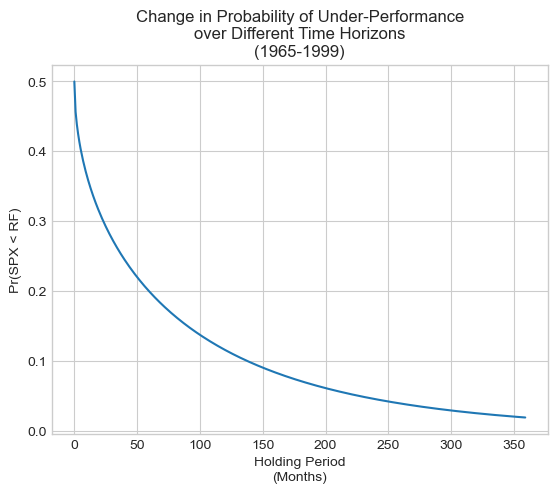

In [16]:
x = np.arange(0, 12*30)
y = prob_under(mu, sigma, c=0, h=x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Change in Probability of Under-Performance\nover Different Time Horizons\n(1965-1999)')
ax.set(xlabel='Holding Period\n(Months)', ylabel='Pr(SPX < RF)')

### 3. Probability Using Sample 1965-2024

**Use the sample 1965-2024 to reconsider the 30-year probability. As of the end of 2024, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{t,t+h}^m$ underperforming $R_{t,t+h}^f$ for $0 < h \leq 30$**

In [17]:
mu = barn_rets.loc['1965':'2024', 'LOG_SPX-XS'].mean()
sigma = barn_rets.loc['1965':'2024', 'LOG_SPX-XS'].std()

print(f'30-year (1965-2024):\n\tPr(SPX Returns < RF Returns) = {prob_under(mu, sigma, c=0, h=12*30):.2%}')

30-year (1965-2024):
	Pr(SPX Returns < RF Returns) = 1.94%


[Text(0.5, 0, 'Holding Period\n(Months)'), Text(0, 0.5, 'Pr(SPX < RF)')]

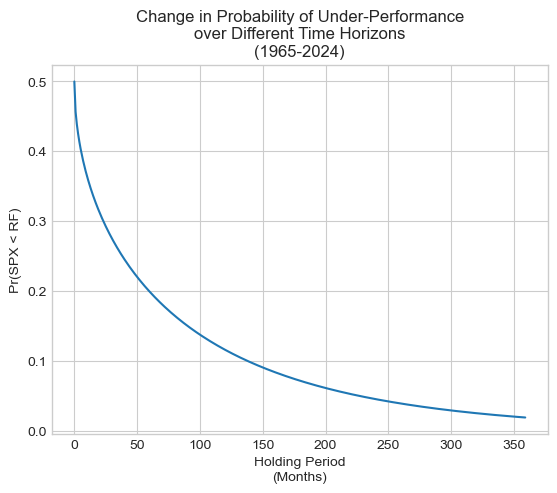

In [18]:
x = np.arange(0, 12*30)
y = prob_under(mu, sigma, c=0, h=x)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Change in Probability of Under-Performance\nover Different Time Horizons\n(1965-2024)')
ax.set(xlabel='Holding Period\n(Months)', ylabel='Pr(SPX < RF)')

### 4. Assessment of Expectations vs. Reality

**Let's consider how things turned out relative to Banstable's 1999 expectations. What was the probability (based on the 1999 estimate of $\mu$) that the 25-year market return, $R_{t,t+25}^m$, would be smaller than that realized in 2000-2024? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$**

In [19]:
mu = barn_rets.loc['1965':'1999', 'LOG_SPX'].mean()
sigma = barn_rets.loc['1965':'1999', 'LOG_SPX'].std()
c = barn_rets.loc['2000':'2024', 'LOG_SPX'].mean()

print(f'Barnstable Hindsight Pr(Under-Performance):\n\tPr(SPX Returns < RF Returns) = {prob_under(mu, sigma, c=c, h=12*25):.2%}')

Barnstable Hindsight Pr(Under-Performance):
	Pr(SPX Returns < RF Returns) = 7.85%
